In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [18]:
from sklearn.model_selection import train_test_split
import os, shutil
from pathlib import Path
from collections import defaultdict

src_dir = Path("/kaggle/input/major-final-kymograms-cropped/final kymograms cropped")
dst_dir = Path("/kaggle/working/tertiary_split")

# Step 1: Gather all images with their class labels
all_images = []
class_map = defaultdict(list)

for cls in os.listdir(src_dir):
    cls_dir = src_dir / cls
    images = list(cls_dir.glob("*.png"))
    for img in images:
        all_images.append((img, cls))  # Store path and class label
        class_map[cls].append(img)

# Step 2: Global split - 15% test
trainval, test = train_test_split(all_images, test_size=0.15, random_state=42, stratify=[label for _, label in all_images])

# Step 3: Split remaining into 70% train, 30% val
train, val = train_test_split(trainval, test_size=0.15, random_state=42, stratify=[label for _, label in trainval])

# Step 4: Copy images to appropriate folders
def copy_images(split_name, data):
    for img_path, cls in data:
        split_dir = dst_dir / split_name / cls
        split_dir.mkdir(parents=True, exist_ok=True)
        shutil.copy(img_path, split_dir / img_path.name)

copy_images("train", train)
copy_images("val", val)
copy_images("test", test)

In [19]:
import random
import shutil
from pathlib import Path

train_dir = Path("/kaggle/working/tertiary_split/train")

# Step 1: Count images in each class
class_counts = {}
for cls_folder in train_dir.iterdir():
    if cls_folder.is_dir():
        class_counts[cls_folder.name] = len(list(cls_folder.glob("*.png")))

# Step 2: Find maximum class count
max_count = max(class_counts.values())

# Step 3: Oversample each class to match max_count
for cls_name, count in class_counts.items():
    cls_path = train_dir / cls_name
    images = list(cls_path.glob("*.png"))
    
    if count < max_count:
        needed = max_count - count
        to_duplicate = random.choices(images, k=needed)  # Randomly pick with replacement

        for i, img in enumerate(to_duplicate):
            # Create new filename to avoid overwriting
            new_name = cls_path / f"{img.stem}_dup{i}{img.suffix}"
            shutil.copy(img, new_name)

print("✅ Training set balanced by oversampling.")

✅ Training set balanced by oversampling.


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from pathlib import Path
from tqdm import tqdm
import os


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet152 without FC layer
resnet152 = models.resnet152(pretrained=True)
resnet152 = torch.nn.Sequential(*(list(resnet152.children())[:-1]))
resnet152.to(device)
resnet152.eval()

# Preprocess pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def extract_features(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = resnet152(image).squeeze().cpu().numpy()
    return features


In [23]:
data_root = Path("/kaggle/working/tertiary_split")
splits = ['train', 'val', 'test']

features = {split: [] for split in splits}
labels = {split: [] for split in splits}
label_map = {}  # for converting class -> index

for split in splits:
    for i, cls_folder in enumerate(sorted((data_root / split).iterdir())):
        if cls_folder.is_dir():
            cls = cls_folder.name
            if cls not in label_map:
                label_map[cls] = len(label_map)
            label_idx = label_map[cls]

            for img_path in tqdm(list(cls_folder.glob("*.png")), desc=f"{split}/{cls}"):
                feat = extract_features(img_path)
                features[split].append(feat)
                labels[split].append(label_idx)

# Convert to numpy arrays
X_train = np.array(features['train'])
y_train = np.array(labels['train'])
X_val = np.array(features['val'])
y_val = np.array(labels['val'])
X_test = np.array(features['test'])
y_test = np.array(labels['test'])


test/organic: 100%|██████████| 236/236 [00:04<00:00, 51.65it/s]


In [24]:
class FeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.X = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = FeatureDataset(X_train, y_train)
val_ds = FeatureDataset(X_val, y_val)
test_ds = FeatureDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)


In [25]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.ReLU(),
            nn.Linear(out_features, out_features),
            nn.BatchNorm1d(out_features)
        )
        self.skip = nn.Sequential()
        if in_features != out_features:
            self.skip = nn.Sequential(nn.Linear(in_features, out_features))

    def forward(self, x):
        identity = self.skip(x)
        out = self.block(x)
        out += identity
        return torch.relu(out)

class ResNet50V2Inspired(nn.Module):
    def __init__(self, input_dim=2048, num_classes=3):
        super().__init__()
        self.net = nn.Sequential(
            ResidualBlock(input_dim, 1024),
            ResidualBlock(1024, 512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = ResNet50V2Inspired(num_classes=len(label_map)).to(device)


Epoch 1/30 | Train Loss: 0.2852 | Train Acc: 0.8907 | Val Loss: 0.1166 | Val Acc: 0.9580
Epoch 2/30 | Train Loss: 0.0812 | Train Acc: 0.9722 | Val Loss: 0.0566 | Val Acc: 0.9818
Epoch 3/30 | Train Loss: 0.0580 | Train Acc: 0.9812 | Val Loss: 0.1128 | Val Acc: 0.9659
Epoch 4/30 | Train Loss: 0.0328 | Train Acc: 0.9904 | Val Loss: 0.0396 | Val Acc: 0.9873
Epoch 5/30 | Train Loss: 0.0499 | Train Acc: 0.9840 | Val Loss: 0.0552 | Val Acc: 0.9810
Epoch 6/30 | Train Loss: 0.0218 | Train Acc: 0.9947 | Val Loss: 0.1049 | Val Acc: 0.9635
Epoch 7/30 | Train Loss: 0.0404 | Train Acc: 0.9876 | Val Loss: 0.0347 | Val Acc: 0.9897
Epoch 8/30 | Train Loss: 0.0230 | Train Acc: 0.9926 | Val Loss: 0.0633 | Val Acc: 0.9794
Epoch 9/30 | Train Loss: 0.0352 | Train Acc: 0.9878 | Val Loss: 0.0338 | Val Acc: 0.9905
Epoch 10/30 | Train Loss: 0.0144 | Train Acc: 0.9955 | Val Loss: 0.0242 | Val Acc: 0.9952
Epoch 11/30 | Train Loss: 0.0275 | Train Acc: 0.9909 | Val Loss: 0.0322 | Val Acc: 0.9929
Epoch 12/30 | Train

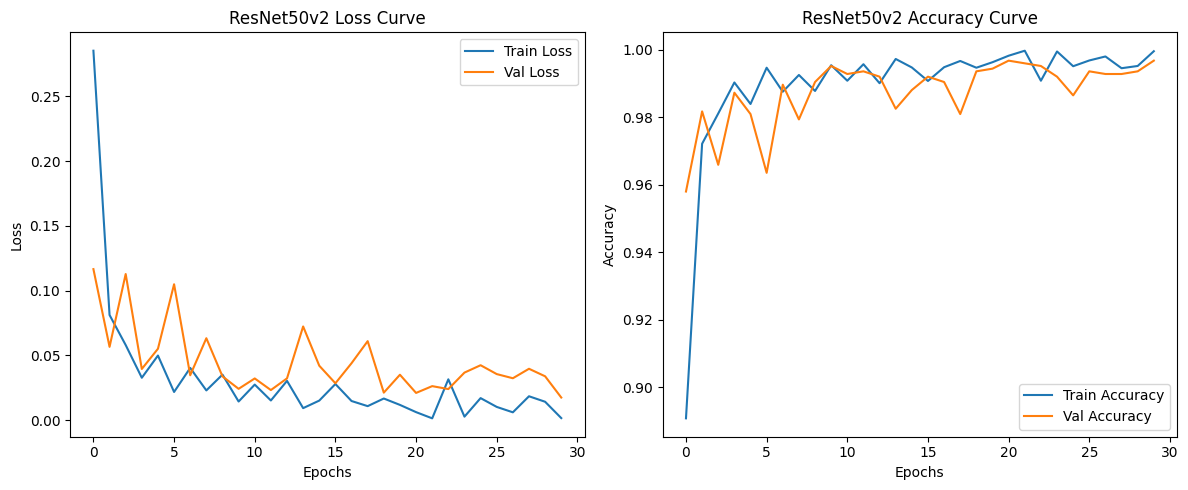

In [26]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

# Assuming model, train_loader, and val_loader are defined
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Initialize the history variable to store metrics
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)

def train_model(model, epochs=30):
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # Training loop
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            out = model(X_batch)
            loss = criterion(out, y_batch)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            correct_train += (out.argmax(dim=1) == y_batch).sum().item()
            total_train += y_batch.size(0)
        
        train_loss = running_train_loss / len(train_loader)
        train_acc = correct_train / total_train

        # Validation loop
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                out = model(X_batch)
                loss = criterion(out, y_batch)

                running_val_loss += loss.item()
                correct_val += (out.argmax(dim=1) == y_batch).sum().item()
                total_val += y_batch.size(0)
        
        val_loss = running_val_loss / len(val_loader)
        val_acc = correct_val / total_val

        # Save metrics to history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print stats for the current epoch
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

# Train the model
train_model(model, epochs=30)
torch.save(model.state_dict(), 'best_model_resnet50v2.pth')
# Plotting the loss and accuracy curves
def plot_training_history(history):
    # Plot loss curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('ResNet50v2 Loss Curve')

    # Plot accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('ResNet50v2 Accuracy Curve')

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)



Validation Set Performance
Metric         Value
------------------------------

Class: functional
AUC (%)          : 100.00
F1 score (%)     : 99.63
Precision (%)    : 100.00
Recall (%)       : 99.25
Sensitivity (%)  : 99.25
Specificity (%)  : 100.00

Class: healthy
AUC (%)          : 99.94
F1 score (%)     : 99.75
Precision (%)    : 99.75
Recall (%)       : 99.75
Sensitivity (%)  : 99.75
Specificity (%)  : 99.57

Class: organic
AUC (%)          : 99.94
F1 score (%)     : 99.50
Precision (%)    : 99.01
Recall (%)       : 100.00
Sensitivity (%)  : 100.00
Specificity (%)  : 99.81
Overall Accuracy : 99.68%


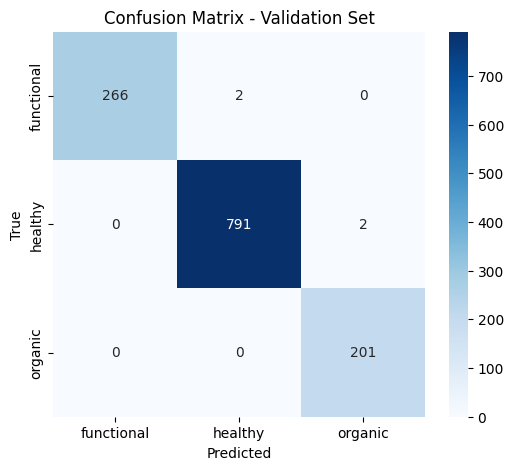

In [35]:
import torch
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.preprocessing import label_binarize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ---------- Evaluation for Validation Set ----------
model.eval()
all_preds = []
all_labels = []
all_probs = []
with torch.no_grad():
    for X_batch, y_batch in val_loader:  # do same for test_loader block
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
y_true_val = np.array(all_labels)
y_pred_val = np.array(all_preds)
y_prob_val = np.array(all_probs)

# Get class names
class_names = list(label_map.keys())

# Accuracy
acc_val = accuracy_score(y_true_val, y_pred_val) * 100

# Classification report
report_val = classification_report(y_true_val, y_pred_val, target_names=class_names, output_dict=True)

# AUC
y_true_val_bin = label_binarize(y_true_val, classes=[0, 1, 2])
auc_scores_val = roc_auc_score(y_true_val_bin, y_prob_val, average=None, multi_class='ovr')

# Confusion matrix
conf_matrix_val = confusion_matrix(y_true_val, y_pred_val)

# Sensitivity & Specificity
def compute_sensitivity_specificity(conf_matrix):
    sensitivity = []
    specificity = []
    for i in range(len(conf_matrix)):
        TP = conf_matrix[i, i]
        FN = conf_matrix[i].sum() - TP
        FP = conf_matrix[:, i].sum() - TP
        TN = conf_matrix.sum() - (TP + FP + FN)

        sensitivity.append(100 * TP / (TP + FN) if (TP + FN) > 0 else 0)
        specificity.append(100 * TN / (TN + FP) if (TN + FP) > 0 else 0)

    return sensitivity, specificity

sensitivity_val, specificity_val = compute_sensitivity_specificity(conf_matrix_val)

# Print Results
print("\nValidation Set Performance")
print(f"{'Metric':<15}{'Value'}")
print("-" * 30)

for i, cls in enumerate(class_names):
    print(f"\nClass: {cls}")
    print(f"AUC (%)          : {auc_scores_val[i] * 100:.2f}")
    print(f"F1 score (%)     : {report_val[cls]['f1-score'] * 100:.2f}")
    print(f"Precision (%)    : {report_val[cls]['precision'] * 100:.2f}")
    print(f"Recall (%)       : {report_val[cls]['recall'] * 100:.2f}")
    print(f"Sensitivity (%)  : {sensitivity_val[i]:.2f}")
    print(f"Specificity (%)  : {specificity_val[i]:.2f}")
print(f"Overall Accuracy : {acc_val:.2f}%")
# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



Test Set Performance
Metric         Value
------------------------------

Class: functional
AUC (%)          : 100.00
F1 score (%)     : 99.63
Precision (%)    : 100.00
Recall (%)       : 99.25
Sensitivity (%)  : 99.25
Specificity (%)  : 100.00

Class: healthy
AUC (%)          : 99.94
F1 score (%)     : 99.75
Precision (%)    : 99.75
Recall (%)       : 99.75
Sensitivity (%)  : 99.75
Specificity (%)  : 99.57

Class: organic
AUC (%)          : 99.94
F1 score (%)     : 99.50
Precision (%)    : 99.01
Recall (%)       : 100.00
Sensitivity (%)  : 100.00
Specificity (%)  : 99.81
Overall Accuracy : 99.68%


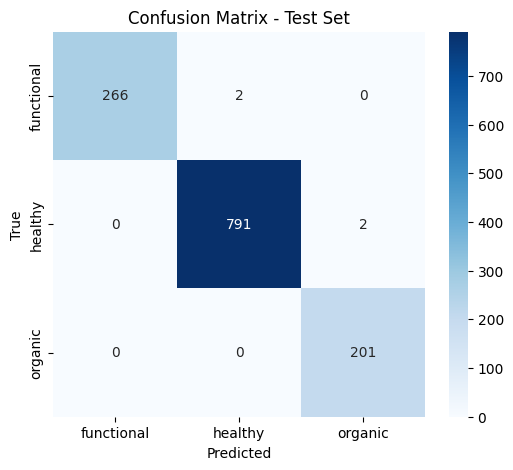

In [33]:
# ---------- Evaluation for Test Set ----------
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:  # do same for test_loader block
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())


y_true_test = np.array(all_labels)
y_pred_test = np.array(all_preds)
y_prob_test = np.array(all_probs)

# Accuracy
acc_test = accuracy_score(y_true_test, y_pred_test) * 100

# Classification report
report_test = classification_report(y_true_test, y_pred_test, target_names=class_names, output_dict=True)

# AUC
y_true_test_bin = label_binarize(y_true_test, classes=[0, 1, 2])
auc_scores_test = roc_auc_score(y_true_test_bin, y_prob_test, average=None, multi_class='ovr')

# Confusion matrix
conf_matrix_test = confusion_matrix(y_true_test, y_pred_test)

# Sensitivity & Specificity
sensitivity_test, specificity_test = compute_sensitivity_specificity(conf_matrix_test)

# Print Results
print("\nTest Set Performance")
print(f"{'Metric':<15}{'Value'}")
print("-" * 30)

for i, cls in enumerate(class_names):
    print(f"\nClass: {cls}")
    print(f"AUC (%)          : {auc_scores_test[i] * 100:.2f}")
    print(f"F1 score (%)     : {report_test[cls]['f1-score'] * 100:.2f}")
    print(f"Precision (%)    : {report_test[cls]['precision'] * 100:.2f}")
    print(f"Recall (%)       : {report_test[cls]['recall'] * 100:.2f}")
    print(f"Sensitivity (%)  : {sensitivity_test[i]:.2f}")
    print(f"Specificity (%)  : {specificity_test[i]:.2f}")
print(f"Overall Accuracy : {acc_test:.2f}%")
# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
